<a href="https://colab.research.google.com/github/ChibuzoKelechi/Sentiment_Classifier_beta/blob/main/sentiment_classifier_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import h5py

from sklearn.model_selection import train_test_split
from tensorflow import keras as tfkeras
from keras import layers, losses
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# reddit_data = '/content/drive/MyDrive/Datasets/Twitter_reddit SA data/Reddit_Data.csv'

reddit_data = '/content/Reddit_Data.csv'
dataset = pd.read_csv(reddit_data)

comments = dataset['clean_comment']
categories = dataset['category']

sentences = []
labels = []

for sentence in comments:
  sentences.append(str(sentence))

for category in categories:
  labels.append(category)

train_size = 28000
vocab_size = 48244
embedding_dim = 50
max_length = 100
trunc_type='post'
pad_type='post'

train_text = sentences[0:train_size]
test_text = sentences[train_size:]

train_labels = labels[0:train_size]
test_labels = labels[train_size:]

In [4]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index


train_sequence = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequence, padding='post', maxlen=100, truncating=trunc_type)

test_sequence = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequence, padding='post', maxlen=100, truncating=trunc_type)

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

test_labels = test_labels[:len(test_padded)]

dataset_shape = dataset.shape

train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

In [5]:
early_stop = tfkeras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

In [6]:
text_model = tfkeras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=100),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(10, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])


text_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [7]:
history = text_model.fit(
    train_padded, train_labels,
    epochs=30,
    validation_data=(test_padded, test_labels),
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/30
875/875 [==============================] - 31s 34ms/step - loss: 0.9394 - accuracy: 0.5637 - val_loss: 0.6368 - val_accuracy: 0.7815
Epoch 2/30
875/875 [==============================] - 28s 32ms/step - loss: 0.5564 - accuracy: 0.7821 - val_loss: 0.5140 - val_accuracy: 0.8226
Epoch 3/30
875/875 [==============================] - 30s 34ms/step - loss: 0.4222 - accuracy: 0.8442 - val_loss: 0.4412 - val_accuracy: 0.8417
Epoch 4/30
875/875 [==============================] - 31s 35ms/step - loss: 0.3415 - accuracy: 0.8772 - val_loss: 0.4813 - val_accuracy: 0.8214
Epoch 5/30
875/875 [==============================] - 28s 32ms/step - loss: 0.2930 - accuracy: 0.8918 - val_loss: 0.5296 - val_accuracy: 0.8303
Epoch 6/30
875/875 [==============================] - 28s 32ms/step - loss: 0.2706 - accuracy: 0.9021 - val_loss: 0.5342 - val_accuracy: 0.8077
Epoch 7/30
875/875 [==============================] - 29s 34ms/step - loss: 0.2460 - accuracy: 0.9111 - val_loss: 0.6587 - val_accuracy:

Minimum validation loss: 0.44119325280189514


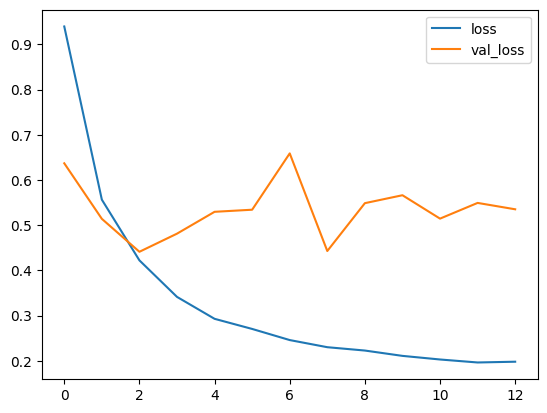

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [9]:
results = text_model.evaluate(test_padded, test_labels, batch_size=50)

print(f'Your model has an accuracy of {100*results[1]}%')

185/185 [==============================] - 0s 2ms/step - loss: 0.4412 - accuracy: 0.8417
Your model has an accuracy of 84.17125940322876%


## Input Classifcation
The Model has been built. Now its time to setup the code for processing and classifiying input sentiment

In [10]:
test_sentences = [
    'I definitely love machine learning, its so cool',
    'Twitter is a really difficult place, so much hate',
    'I am okay, not so bad',
    'Oh I am overflowing with joy and happiness'
]


def preprocess_text(text):
  text = text.lower()
  input_sequence = tokenizer.texts_to_sequences([text])
  input_padded = pad_sequences(input_sequence, maxlen=100, padding='post')

  return input_padded


In [11]:
input_text = test_sentences[1]
input = preprocess_text(input_text)

score = text_model.predict(input)

sentiment_classes = {0:'neutral', 1:'positive', 2:'negative'}

predicted_class = np.argmax(score)
certainty = 100 * np.max(score)

print(f'Input Sentence: {input_text}')
print(f'Predicted: {sentiment_classes[predicted_class]}')
print(f'Certainty: {certainty:.2f}%')

1/1 [==============================] - 0s 125ms/step
Input Sentence: Twitter is a really difficult place, so much hate
Predicted: negative
Certainty: 96.49%


In [14]:
text_model.save('sentiment_model_tf.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
